In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os import path
import pickle
import scipy.optimize as opt
pd.options.display.max_seq_items = 2000

In [2]:
openfile=open( r"C:\Users\Joseph\Documents\Beamly\TakeHomeTask\beamly_case_study_noNaNs.pickle", "rb")
df=pickle.load(openfile)
openfile.close()

In [3]:
device_date=df.groupby(by=['device_name', 'date']).sum()

In [4]:

df_e=df
df_e['weekday']=df['date'].apply(lambda x:pd.to_datetime(x).weekday())
device_weekday=df_e.groupby(by=['productBand', 'weekday']).sum()['total_products'].unstack(0)

In [5]:
modelling_df=df.groupby(by=['productBand', 'date']).sum()['total_products'].unstack(0)

In [26]:

def salescount_poisson(B12,B23):
    var1,var2=0.5646645900308181,0.3583200942112118
    return (var1*B12+var2*B23)/2.


In [27]:
def scale_total_products_modelling(row,dwd,col):
    scaler=dwd[col].apply(lambda x:x/dwd[col].mean())
    weekday_temp=pd.to_datetime(row.name).weekday()
    #print(scaler,weekday_temp,scaler[weekday_temp])
    return row[col]/scaler[weekday_temp]
forecast_august=modelling_df
for column in modelling_df.columns:
    forecast_august[column]=modelling_df.apply(lambda row:scale_total_products_modelling(row,device_weekday,column),axis=1)
forecast_august['between30and40']=forecast_august.apply(lambda x:salescount_poisson(x['between10and20'],x['between20and30']),axis=1)
forecast_august.drop(forecast_august.index[len(forecast_august)-1])
forecast_august

productBand,between10and20,between20and30,between40and50,lessThan10,moreThan50,price_missing,between30and40
date,,,,,,,
2018-07-01,202.665271,232.348721,35.709326,160.565870,11.940316,54.190193,98.846559
2018-07-02,159.318553,186.325311,22.926622,127.211538,17.038164,54.757187,78.362824
2018-07-03,182.522365,192.519493,15.206955,79.388100,19.102041,43.694746,86.023760
2018-07-04,255.099620,273.590272,31.063421,204.423087,30.727031,46.497542,121.039307
2018-07-05,252.887936,300.742019,53.509776,229.726441,41.670333,38.287090,125.279386
2018-07-06,320.135695,348.218486,54.545535,270.656022,46.357079,47.149956,152.771486
2018-07-07,245.684799,311.386326,54.386538,197.515070,9.103989,31.869521,125.152742
2018-07-08,199.889035,241.440628,33.967408,156.551724,13.930368,27.095096,99.691644
2018-07-09,165.123682,206.412426,37.255761,167.658284,13.311066,31.941692,83.600608


In [28]:
def movingaverage(interval, window_size):
    """ 
    A function to calculate a moving average, useful for looking at data trends and for dampening noise in a less artificial way.
    """
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

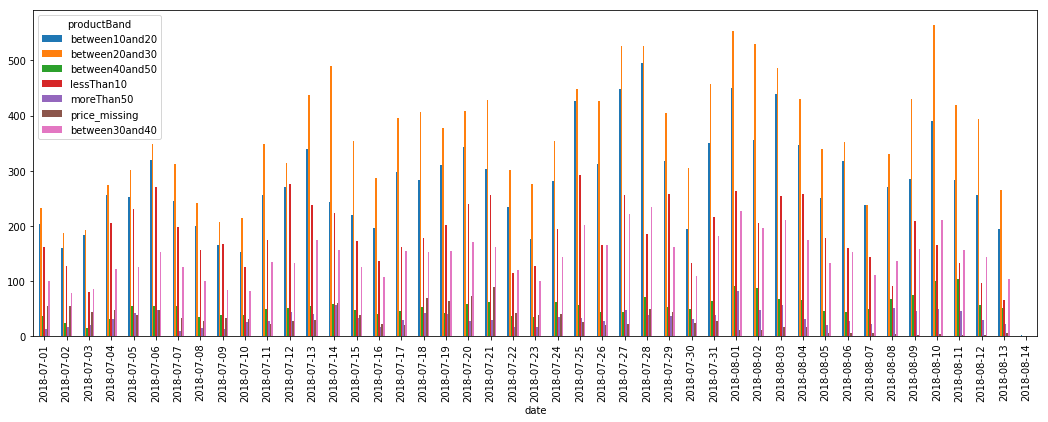

In [29]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august.plot(kind='bar', ax=ax)

## Forecast New Line
Estimate the sales of the new line from this forecasting.

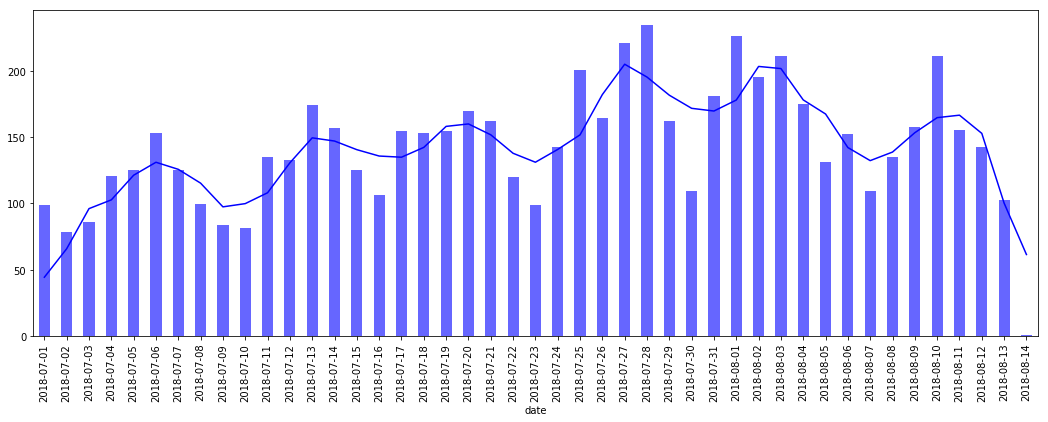

In [35]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
move_av_30to40=movingaverage(forecast_august['between30and40'].values,4)
ax.plot(move_av_30to40,color='blue')

In [36]:
def monthly_trend_forecaster(t,x):
    return x[0]*np.sin(x[1]*t+x[2]) + x[3]

In [40]:
forecast_august.reset_index(inplace=True)

In [58]:
#between20and30 first
y=forecast_august['between30and40'].values
x1=forecast_august.index
guess_mean = np.mean(y)
guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
o1, success = opt.leastsq(errfunc, guess[:], args=(x1, y))
print(o1,success)
print(np.mean(y))

[-3.84445818e+01 -1.29089558e-01  2.70778105e+01  1.40175069e+02] 1
142.6019820218151


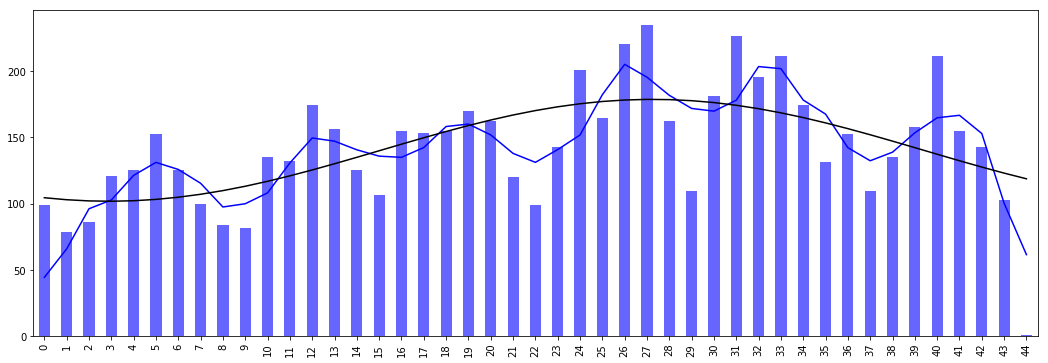

In [59]:
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40,color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o1),color='k')

[ 26.72132477   0.88137345   3.73025232 142.52346781] 1
141.47725144191412


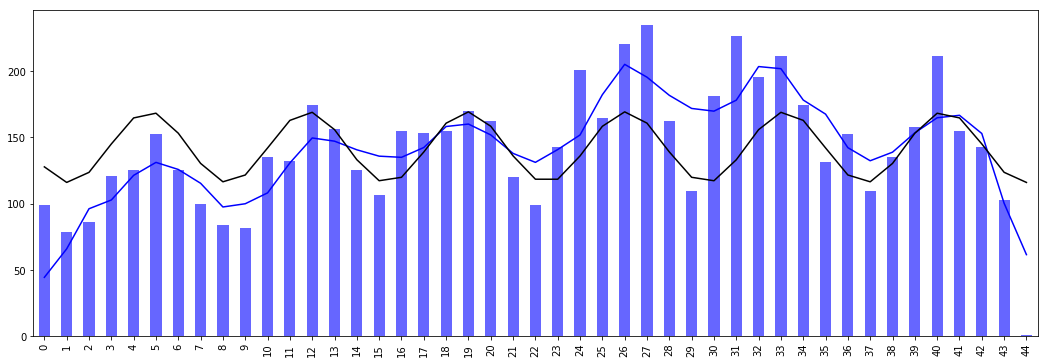

In [61]:
#between20and30 first
move_av_30to40=movingaverage(forecast_august['between30and40'].values,4)
y=move_av_30to40
x1=forecast_august.index
guess_mean = np.mean(y)
guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1
guess= [guess_amp, guess_freq, guess_phase, guess_mean]
errfunc = lambda o, x1, y: monthly_trend_forecaster(x1,o) - y # Distance to the target function, through linear combination.
o2, success = opt.leastsq(errfunc, guess[:], args=(x1, y))
print(o2,success)
print(np.mean(y))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40,color='blue')
ax.plot(x1,monthly_trend_forecaster(x1,o2),color='k')

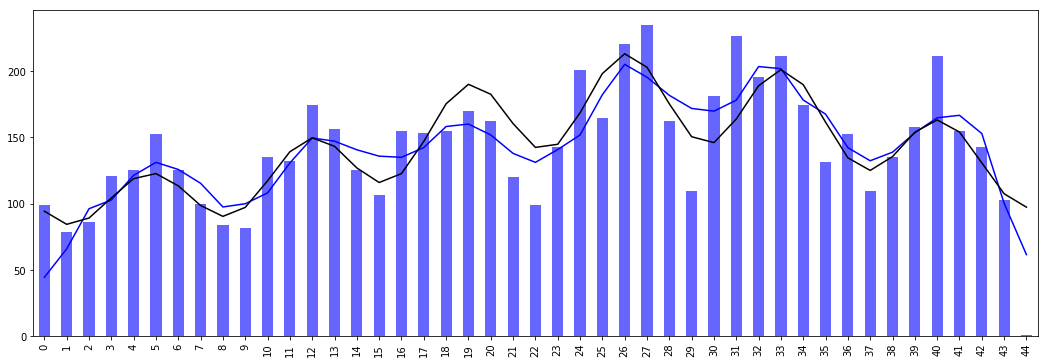

In [68]:
#def comb_func(x1,o1,o2):
#    return (monthly_trend_forecaster(x1,o1)+monthly_trend_forecaster(x1,o2))/2.#This dampens the signal a little, better to use the lower function
def comb_func(x1,o1,o2):
    return (monthly_trend_forecaster(x1,o1)*monthly_trend_forecaster(x1,o2))/np.mean(monthly_trend_forecaster(x1,o2))
f, ax = plt.subplots(1,figsize=(18,6))
forecast_august['between30and40'].plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='between30and40')
ax.plot(move_av_30to40,color='blue')
ax.plot(x1,comb_func(x1,o1,o2),color='k')

## Forecast Sales for last two weeks
In coding terms this is from days 44->60

In [73]:
newdates=np.arange(44,61,1)
b34sales=comb_func(newdates,o1,o2)

In [76]:
df_b34=pd.DataFrame(b34sales,index=newdates)
df_b34

,0
44,98.073885
45,104.415890
46,119.106222
47,128.957115
48,125.263637
49,109.532728
50,91.946508
51,84.059666
52,90.860700
53,107.453070


assign new dates

In [88]:
def assigndates(row):
    r44=pd.to_datetime('2018-08-14')
    year = r44.year
    month = r44.month
    day = r44.day+(row.name-44)
    return datetime.date(year, month, day)
df_b34['date']=df_b34.apply(lambda row:assigndates(row),axis=1)
df_b34

44 Index([0, 'date'], dtype='object')
45 Index([0, 'date'], dtype='object')
46 Index([0, 'date'], dtype='object')
47 Index([0, 'date'], dtype='object')
48 Index([0, 'date'], dtype='object')
49 Index([0, 'date'], dtype='object')
50 Index([0, 'date'], dtype='object')
51 Index([0, 'date'], dtype='object')
52 Index([0, 'date'], dtype='object')
53 Index([0, 'date'], dtype='object')
54 Index([0, 'date'], dtype='object')
55 Index([0, 'date'], dtype='object')
56 Index([0, 'date'], dtype='object')
57 Index([0, 'date'], dtype='object')
58 Index([0, 'date'], dtype='object')
59 Index([0, 'date'], dtype='object')
60 Index([0, 'date'], dtype='object')


,0,date
44,98.073885,2018-08-14
45,104.415890,2018-08-15
46,119.106222,2018-08-16
47,128.957115,2018-08-17
48,125.263637,2018-08-18
49,109.532728,2018-08-19
50,91.946508,2018-08-20
51,84.059666,2018-08-21
52,90.860700,2018-08-22
53,107.453070,2018-08-23


In [89]:
df_b34.reset_index(inplace=True)
df_b34.set_index('date',inplace=True)
df_b34.head()

,index,0
date,,
2018-08-14,44,98.073885
2018-08-15,45,104.415890
2018-08-16,46,119.106222
2018-08-17,47,128.957115
2018-08-18,48,125.263637


In [97]:
df_b34.drop(['index'],axis=1,inplace=True)

In [100]:
df_b34.rename(columns={0: "forecast_B30to40"},inplace=True)

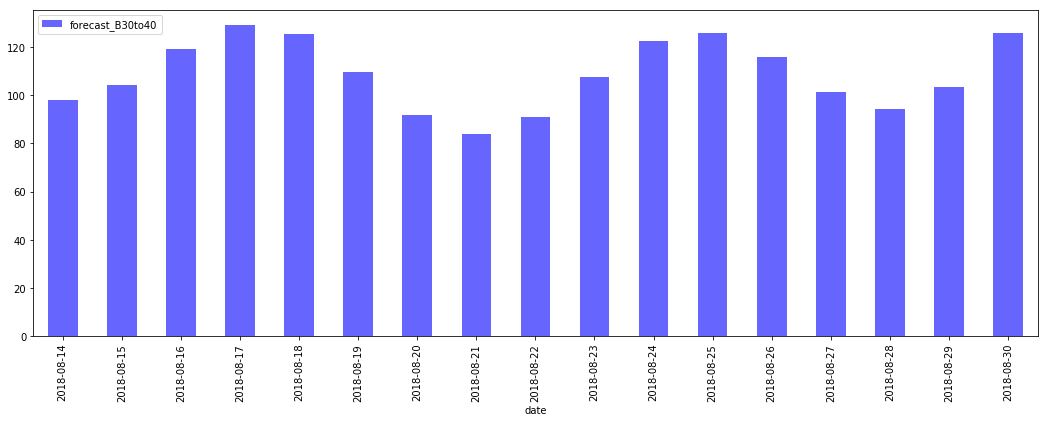

In [101]:
f, ax = plt.subplots(1,figsize=(18,6))
df_b34.plot(kind='bar', ax=ax,color='blue',alpha=0.6,label='Forecast_30to40')